<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/HW_221031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **8.5 감성 분석**

### **a. 감성 분석 소개**
  - 감성 분석
    - 문서의 주관적인 감성/의견/감정/기분 등을 파악하기 위한 방법으로 소셜 미디어, 여론조사, 온라인 리뷰, 피드백 등 다양한 분야에서 활용
    - 문서 내 텍스트가 나타내는 여러 가지 주관적인 단어와 문맥을 기반으로 감성 수치를 계산하는 방법을 이용
    - 감성 지수는 긍정 감정 지수와 부정 감정 지수로 구성되며, 이들 지수를 합산해 긍정 감성 또는 부정 감성을 결정
    - 감성 분석은 지도학습과 비지도학습 방식으로 구분
      - 지도학습 : 학습 데이터와 타깃 레이블 값을 기반으로 감성 분석 학습을 수행한 뒤 이를 기반으로 다른 데이터의 감성 분석을 예측하는 방법으로, 일반적인 텍스트 기반의 분류와 거의 동일
      - 비지도학습 : '`Lexicon`'이라는 일종의 감성 어휘 사전을 이용

### **b. `지도학습 기반` 감성 분석 실습 - IMDB 영화평**
  - 영화평의 텍스트를 분석해 감성 분석 결과가 긍정 또는 부정인지를 예측하는 모델을 생성해보자.

In [2]:
import pandas as pd

review_df = pd.read_csv('labeledTrainData.tsv', header = 0, sep = '\t', quoting = 3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


  - id : 각 데이터의 id
  - sentiment : 영화평의 Sentiment 결과 값(Target Label). 1은 긍정적 평가, 0은 부정적 평가를 의미
  - review : 영화평의 텍스트

  - 텍스트가 어떻게 구성돼 있는지 review 칼럼의 텍스트 값을 하나만 살펴보자.

In [3]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

  - HTML 형식에서 추출해 `<br />` 태그가 여전히 존재한다. replace()를 str에 적용해 `<br />` 태그를 `공백으로 모두 변경`한다.
  - 또한 `영어가 아닌 숫자/특수문자` 역시 Sentiment를 위한 피처로는 별 의미가 없으므로 이들도 모두 `공란으로 변경`한다.
    - `정규 표현식을 이용`해 숫자/특수문자를 찾고 이를 변환한다.
    - 파이썬의 re 모듈은 편리하게 정규 표현식을 지원한다.
    - `re.sub('[^a-zA-Z]', '', x)`는 영어 대/소문자가 아닌 `모든 문자를 찾아서 공란으로 변경`

In [4]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# 파이썬의 정규 표현식 모듈인 re를 이용해 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x : re.sub("[^a-zA-Z]", " ", x))

  - 결정 값 클래스인 sentiment 칼럼을 별도로 추출해 `결정 값 데이터 세트`를 만들고, 원본 데이터 세트에서 id와 sentiment 칼럼을 삭제해 `피처 데이터 세트`를 생성한다.
  - 그리고 train_test_split()을 이용해 학습용과 테스트용 데이터 세트로 분리한다.

In [7]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id', 'sentiment'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size = 0.3,
                                                    random_state = 156)

X_train.shape, X_test.shape

((17500, 1), (7500, 1))

- 이제 감상평 `텍스트를 피처 벡터화`한 후에, ML 알고리즘을 적용해 `예측 성능을 측정`해보자. 
- 앞에서 설명한 Pipeline 객체를 이용해 이 두가지를 한꺼번에 수행한다.
- 먼저 `Count 벡터화`를 이용해 예측 성능을 측정하고, 다음으로 `TF-IDF 벡터화`를 적용해보자. 
- Classifier는 `LogisticRegression`을 이용하며, 예측 성능 평가는 이진 분류임을 고려해 테스트 데이터 세트의 `정확도와 ROC-AUC를 모두 측정`한다.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, filtering, ngram은 (1, 2)로 설정해 CountVectorization 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words = 'english', ngram_range = (1,2))),
    ('lr_clf', LogisticRegression(C = 10))
])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행
# predict_proba()는 roc_auc 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


예측 정확도는 0.8860, ROC-AUC는 0.9503


  - 다음으로 TF-IDF 벡터화를 적용해 다시 예측 성능을 측정해보자.

In [10]:
# 스톱 워드는 english, filtering, ngram은 (1, 2)로 설정해 TF-IDF 벡터화 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2))),
    ('lr_clf', LogisticRegression(C = 10))
])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


  - TF-IDF 기반 피처 벡터화의 예측 성능이 조금 더 나은 것을 확인할 수 있다.

### **c. `비지도학습 기반` 감성 분석 소개**
  - 많은 감성 분석용 데이터는 결정된 레이블 값을 가지고 있지 않으므로, 이러한 경우 `Lexicon`을 이용해 `비지도학습 감성 분석`을 진행한다.
  - `Lexicon`은 감성만을 분석하기 위해 지원하는 `감성 어휘 사전`이다.
    - 감성 지수 : 긍정 감성 또는 부정 감성의 정도를 의미하는 수치
    - 감성 지수는 단어의 위치나 주변 단어, 문맥, POS(Part of Speech) 등을 참고해 결정
  - `감성 사전`을 구현한 대표격은 `NLTK 패키지`
    - NLTK는 많은 서브 모듈을 가지고 있으며, 그 중 감성 사진인 Lexicon 모듈도 포함되어 있다.

  - 감성 사전을 좀 더 상세히 이해하기 위해 `NLP` 패키지의 `WordNet`을 먼저 알아보자.
    - WordNet 모듈은 단순한 어휘 사전이 아닌, 시맨틱 분석을 제공하는 어휘 사전
    - 여기서 시맨틱은 간단히 표현하면 '문맥상의 의미'이다.
    - NLP 패키지는 시맨틱을 프로그램적으로 인터페이스할 수 있는 다양한 방법을 제공

  - 이처럼 WordNet은 다양한 상황에서 같은 어휘라도 다르게 사용되는 어휘의 시맨틱 정보를 제공하며, 이를 위해 각각의 품사로 구성된 개별 단어를 Synset(Sets of cognitive synonyms)이라는 개념을 이용해 표현한다. Synset은 단순한 하나의 단어가 아니라 그 단어가 가지는 문맥, 시맨틱 정보를 제공하는 WordNet의 핵심 개념이다.

  - NLTK의 감성 사전은 예측 성능이 그리 좋지 못하다는 단점이 있기 때문에, 실제 업무의 적용은 NLTK 패키지가 아닌 다른 감성 사전을 적용하는 것이 일반적이다. NLTK를 포함한 `대표적인 감성 사전`은 다음과 같다.
    - `SentiWordNet` : NLTK 패키지의 WordNet과 유사하게 감성 단어 전용의 WordNet을 구현한 것. WordNet의 Synset 개념을 감성 분석에 적용한 것. WordNet의 Synset별로 3가지 감성 점수를 할당하는데, 긍정 감성 지수, 부정 감성 지수, 객관성 지수가 그것. 
    - `VADER` : 주로 소셜 미디어의 텍스트에 대한 감성 분석을 제공하기 위한 패키지. 뛰어난 감성 분석 결과를 제공하며, 비교적 빠른 수행 시간을 보장해 대용량 텍스트 데이터에 잘 사용되는 패키지.
    - `Pattern` : 예측 성능 측면에서 가장 주목받는 패키지. 현재 기준으로 파이썬 3.x 버전에서 호환이 되지 않고, 파이썬 2.x 버전에서만 동작.

### **d. SentiWordNet을 이용한 감성 분석**
  1. WordNet Synset과 SentiWordNet SentiSynset 클래스의 이해

  - SentiWordNet은 WordNet 기반의 synset을 이용하므로, 먼저 synset에 대한 개념을 이해한 후에 SentiWordNet을 살펴보자.
  - WordNet을 이용하기 위해서는 NLTK를 셋업한 후에, WordNet 서브패키지와 데이터 세트를 내려받아야 한다.

In [11]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

  - NLTK의 모든 데이터 세트를 내려받은 뒤, WordNet 모듈을 임포트해서 'present' 단어에 대한 Synset을 추출해보자.
  - WordNet의 `synsets()`는 파라미터로 지정된 단어에 대한 `WordNet에 등재된 모든 Synset 객체를 반환`한다.

In [12]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성
synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 개수 :', len(synsets))
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 개수 : 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


  - 총 18개의 서로 다른 semantic을 가지는 synset 객체가 반환되었다. 
  - Synset('present.n.01')와 같이 Synset 객체의 파라미터 'present.n.01'은 POS 태그를 나타낸다. 'present.n.01'에서 present는 의미, n은 명사 품사, 01은 present가 명사로서 사지는 의미가 여러 가지 있어 이를 구분하는 인덱스이다.

  - synset 객체가 가지는 여러 가지 속성을 살펴보자.

In [13]:
for synset in synsets :
  print('##### Synset name :', synset.name(), '#####')
  print('POS :', synset.lexname())
  print('Definition :', synset.definition())
  print('Lemmas :', synset.lemma_names())

##### Synset name : present.n.01 #####
POS : noun.time
Definition : the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas : ['present', 'nowadays']
##### Synset name : present.n.02 #####
POS : noun.possession
Definition : something presented as a gift
Lemmas : ['present']
##### Synset name : present.n.03 #####
POS : noun.communication
Definition : a verb tense that expresses actions or states at the time of speaking
Lemmas : ['present', 'present_tense']
##### Synset name : show.v.01 #####
POS : verb.perception
Definition : give an exhibition of to an interested audience
Lemmas : ['show', 'demo', 'exhibit', 'present', 'demonstrate']
##### Synset name : present.v.02 #####
POS : verb.communication
Definition : bring forward and present to the mind
Lemmas : ['present', 'represent', 'lay_out']
##### Synset name : stage.v.01 #####
POS : verb.creation
Definition : perform (a play), especially on a stage
Lemmas : ['stage', 'present', 're

  - 위와 같이 Synset('present.n.01')과 Synset('present.n.02')는 명사지만 서로 다른 의미를 갖는다. 
  - 이처럼 synset은 하나의 단어가 가질 수 있는 여러 가지 시맨틱 정보를 개별 클래스로 나타낸 것이다.

  - WordNet은 어떤 어휘와 다른 어휘 간의 관계를 유사도로 나타낼 수 있다.
  - synset 객체는 `단어 간의 유사도`를 나타내기 위해 `path_similarity()` 메서드를 제공한다.

In [14]:
# synset 객체를 단어별로 생성한다.
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree, lion, tiger, cat, dog]
similarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset과 유사도를 측정한다.
for entity in entities :
  similarity = [round(entity.path_similarity(compared_entity), 2)
                for compared_entity in entities]
  similarities.append(similarity)

# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFrame 형태로 저장한다.
similarity_df = pd.DataFrame(similarities, columns = entity_names, index = entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


  - lion은 tree와의 유사도가 0.07로 가장 적고, tiger와는 유사도가 0.33으로 가장 크다.

  - `SentiWordNet`은 WordNet의 Synset과 유사한 `Senti_Synset 클래스`를 가지고 있다.
  - SentiWordNet 모듈의 `senti_synsets()`는 WordNet 모듈이라서 synsets()와 비슷하게 `Senti_Synset 클래스를 리스트 형태로 반환`한다.

In [15]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type :', type(senti_synsets))
print('senti_synsets() 반환 값 개수 :', len(senti_synsets))
print('senti_synsets() 반환 값 :', senti_synsets)

senti_synsets() 반환 type : <class 'list'>
senti_synsets() 반환 값 개수 : 11
senti_synsets() 반환 값 : [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


  - SentiSynset 객체는 단어의 감성을 나타내는 감성 지수와 객관성을 나타내는 객관성 지수를 가지고 있다. 감성 지수는 다시 긍정 감성 지수와 부정 감성 지수로 나뉜다.
  - 어떤 단어가 전혀 감성적이지 않으면 객관성 지수는 1, 감성 지수는 모두 0이 된다.

In [17]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수: ', father.pos_score())
print('father 부정감성 지수: ', father.neg_score())
print('father 객관성 지수: ', father.obj_score())
print('\n')

fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수: ', fabulous.pos_score())
print('fabulous 부정감성 지수: ', fabulous.neg_score())

father 긍정감성 지수:  0.0
father 부정감성 지수:  0.0
father 객관성 지수:  1.0


fabulous 긍정감성 지수:  0.875
fabulous 부정감성 지수:  0.125


  - father는 객관적인 단어로, 객관성 지수가 1.0이고 긍정 감성/부정 감성 지수 모두 0이다.
  - 반면 fabulous는 감성 단어로서, 긍정 감성 지수가 0.875이고 부정 감성 지수가 0.125이다.

  2. SentiWordNet을 이용한 영화 감상평 감성 분석
  - 이제 WordNet과 SentiWordNet을 개략적으로 살펴봤으니, 이를 이용해 앞의 예제에서 적용한 `IMDB 영화 감성평 감성 분석`을 `SentiWordNet Lexicon 기반으로 수행`해보자.
  - SentiWordNet을 이용해 감성 분석을 수행하는 개략적인 순서는 다음과 같다.
      1. 문서(Document)를 문장(Sentence) 단위로 분해
      2. 다시 문장을 단어(Word) 단위로 토큰화시키고 품사 태깅
      3. 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
      4. Senti_synset에서 긍정 감성/부정 감성 지수를 구하고 이를 모두 합산해 특정 임계치 값 이상일 때 긍정 감성으로, 그렇지 않을 때는 부정 감성으로 결정

  - SentiWordNet을 이용하기 위해서 WordNet을 이용해 `문서를 다시 단어로 토큰화`한 뒤, `어근 추출(Lemmatization)`과 `품사 태킹(POS Tagging)`을 적용해야 한다.

  - 먼저 품사 태깅을 수행하는 내부 함수를 생성한다.

In [18]:
from nltk.corpus import wordnet as wn

# 간단한 NLTK PennTreebank Tag를 기반으로 WordNet 기반의 품사 Tag로 변환
def penn_to_wn(tag):
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB

  - 이제 문서를 문장 -> 단어 토큰 -> 품사 태깅 후에 SentiSynset 클래스를 생성하고 Polarity Score를 합산하는 함수를 생성한다. 
  - 각 단어의 긍정 감성 지수와 부정 감성 지수를 모두 합한 총 감성 지수가 0 이상일 경우 긍정 감성, 그렇지 않을 경우 부정 감성으로 예측한다.

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
  # 감성 지수 초기화
  sentiment = 0.0
  tokens_count = 0

  lemmatizer = WordNetLemmatizer()
  raw_sentences = sent_tokenize(text)
  # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산
  for raw_sentence in raw_sentences:
    # NLTK 기반의 품사 태깅 문장 추출
    tagged_sentence = pos_tag(word_tokenize(raw_sentence))
    for word, tag in tagged_sentence:

      # WordNet 기반 품사 태깅과 어근 추출
      wn_tag = penn_to_wn(tag)
      if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        continue
      lemma = lemmatizer.lemmatize(word, pos = wn_tag)
      if not lemma:
        continue

      # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성
      synsets = wn.synsets(lemma, pos = wn_tag)
      if not synsets:
        continue
      
      # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
      # 모든 단어에 대해 긍정 감성 지수는 +로, 부정 감성 지수는 -로 합산해 감성 지수 계산
      synset = synsets[0]
      swn_synset = swn.senti_synset(synset.name())
      sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
      tokens_count += 1

  if not tokens_count:
    return 0

  # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
  if sentiment >= 0:
    return 1

  return 0

  - 이렇게 생성한 swn_polarity(text) 함수를 IMDB 감상평의 개별 문서에 적용해 긍정 및 부정 감성을 예측해보자. 
  - 판다스의 apply lambda 구문을 이용해 swn_polarity(text)를 개별 감상평 텍스트에 적용한다.
  - 지도학습에서 사용한 review_df를 그대로 사용하며, review_df의 새로운 칼럼으로 '`preds`'를 추가해 이 칼럼에 `swn_polarity(text)로 반환된 감성 평가를 담는다`.
  - 그리고 실제 감성 평가인 '`sentiment`' 칼럼과 `swn_polarity(text)로 반환된 결과`의 `정확도`, `정밀도`, `재현율` 값을 모두 측정해본다.

In [20]:
review_df['preds'] = review_df['review'].apply(lambda x : swn_polarity(x))
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

  - SentiWordNet의 감성 분석 예측 성능을 살펴보자.

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print('정확도 :', np.round(accuracy_score(y_target, preds), 4))
print('정밀도 :', np.round(precision_score(y_target, preds), 4))
print('재현율 :', np.round(recall_score(y_target, preds), 4))

[[7668 4832]
 [3636 8864]]
정확도 : 0.6613
정밀도 : 0.6472
재현율 : 0.7091


  - 정확도가 약 66.13%, 재현율이 약 70.91%로 전반적인 성능 평가 지표는 그닥 만족스럽지 않은 수치이다.

### **e. VADER를 이용한 감성 분석**
  - VADER
    - `소셜 미디어의 감성 분석 용도`로 만들어진 룰 기반의 Lexicon
    - `SentimentIntensityAnalyzer` 클래스를 이용해 쉽게 `감성 분석을 제공`

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


  - VADER를 이용한 감성 분석
    1. SentimentIntensityAnalyzer 객체를 생성한 뒤, 문서별로 `polarity_scores()` 메서드를 호출해 `감성 점수`를 구한다.
    2. 해당 문서의 감성 점수가 특정 임계값 이상이면 긍정, 그렇지 않으면 부정으로 판단한다.

  - SentimentIntensityAnalyzer 객체의 `polarity_scores()` 메서드는 딕셔너리 형태의 `감성 점수를 반환`한다.
    - `neg`는 `부정 감성` 지수, `neu`는 `중립적인 감성` 지수, `pos`는 `긍정 감성` 지수, `compound`는 neg, neu, pos score를 `적절히 조합해 -1에서 1 사이의 감성 지수`를 표현한 값
    - `compound score`를 기반으로 부정 감성 또는 긍정 감성 여부를 결정
      - 보통 `0.1 이상이면 긍정` 감성, `그 이하이면 부정` 감성으로 판단하나 상황에 따라 임계값을 적절히 조정해 예측 성능을 조절 

  - VADER를 이용해 IMDB의 감성 분석을 수행하기에 앞서, vader_polarity() 함수를 새롭게 생성한다.
  - `vader_polarity()` 함수는 입력 `파라미터`로 `영화 감상평 텍스트`와 `긍정/부정을 결정하는 임곗값`을 가지며, SentimentIntensityAnalyzer 객체의 `polarity_scores()` 메서드를 호출해 `감성 결과를 반환`한다.

In [23]:
def vader_polarity(review, threshold = 0.1):
  analyzer = SentimentIntensityAnalyzer()
  scores = analyzer.polarity_scores(review)

  # compound 값에 기반해 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
  agg_score = scores['compound']
  final_sentiment = 1 if agg_score >= threshold else 0
  return final_sentiment

# apply lambda 식을 이용해 레코드별로 vader_polarity()를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply(lambda x : vader_polarity(x, 0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix(y_target, vader_preds))
print('정확도 :', np.round(accuracy_score(y_target, vader_preds), 4))
print('정밀도 :', np.round(precision_score(y_target, vader_preds), 4))
print('재현율 :', np.round(recall_score(y_target, vader_preds), 4))

[[ 6747  5753]
 [ 1858 10642]]
정확도 : 0.6956
정밀도 : 0.6491
재현율 : 0.8514


  - 정확도가 SentiWordNet에 비해 향상되었고, 특히 재현율은 약 85.14%로 매우 크게 향상되었다. 
  - 다음은 SentiWordNet과 VADER의 IMDB 영화 감상평을 기반으로 지금까지 수행한 감성 분석 평가 지표 수치 결과를 나열한 것이다.

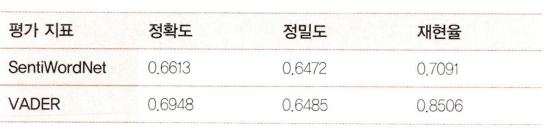